<a href="https://colab.research.google.com/github/Nadaramadan1/StarUnion_Projects/blob/main/Covid_19_Classification_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data processing

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import random
import cv2
import glob
import plotly.express as px
import seaborn as sns
import shutil
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Input, Dropout,Flatten, Conv2D,BatchNormalization,MaxPooling2D,GlobalAveragePooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.utils import plot_model
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.preprocessing.image import load_img
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from IPython.display import SVG, Image
from PIL import Image, UnidentifiedImageError
from shutil import copyfile


In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("tawsifurrahman/covid19-radiography-database")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'covid19-radiography-database' dataset.
Path to dataset files: /kaggle/input/covid19-radiography-database


In [ ]:
print(os.listdir(path))

['COVID-19_Radiography_Dataset']


In [ ]:
COVID_19_Radiography_Dataset = path +"/COVID-19_Radiography_Dataset"

In [ ]:
print(os.listdir(COVID_19_Radiography_Dataset))

['Lung_Opacity.metadata.xlsx', 'Normal.metadata.xlsx', 'README.md.txt', 'COVID.metadata.xlsx', 'Normal', 'Lung_Opacity', 'Viral Pneumonia.metadata.xlsx', 'Viral Pneumonia', 'COVID']


In [ ]:
covid = COVID_19_Radiography_Dataset + "/COVID/images"
normal = COVID_19_Radiography_Dataset + "/Normal/images"
viral = COVID_19_Radiography_Dataset + "/Viral Pneumonia/images"
lung_opacity = COVID_19_Radiography_Dataset + "/Lung_Opacity/images"

In [ ]:
print(f"COVID: {len(os.listdir(covid))}")
print(f"Normal: {len(os.listdir(normal))}")
print(f"Viral: {len(os.listdir(viral))}")
print(f"Lung Opacity: {len(os.listdir(lung_opacity))}")

COVID: 3616
Normal: 10192
Viral: 1345
Lung Opacity: 6012


In [ ]:
covid_df = COVID_19_Radiography_Dataset + "/COVID.metadata.xlsx"
covid_df = pd.read_excel(covid_df)
print(covid_df.shape)
covid_df.head()

(3616, 4)


,FILE NAME,FORMAT,SIZE,URL
0,COVID-1,PNG,256*256,https://sirm.org/category/senza-categoria/covi...
1,COVID-2,PNG,256*256,https://sirm.org/category/senza-categoria/covi...
2,COVID-3,PNG,256*256,https://sirm.org/category/senza-categoria/covi...
3,COVID-4,PNG,256*256,https://sirm.org/category/senza-categoria/covi...
4,COVID-5,PNG,256*256,https://sirm.org/category/senza-categoria/covi...


In [ ]:
normal_df = COVID_19_Radiography_Dataset + "/Normal.metadata.xlsx"
normal_df = pd.read_excel(normal_df)
print(normal_df.shape)
normal_df.head()

(10192, 4)


,FILE NAME,FORMAT,SIZE,URL
0,NORMAL-1,PNG,256*256,https://www.kaggle.com/c/rsna-pneumonia-detect...
1,NORMAL-2,PNG,256*256,https://www.kaggle.com/c/rsna-pneumonia-detect...
2,NORMAL-3,PNG,256*256,https://www.kaggle.com/c/rsna-pneumonia-detect...
3,NORMAL-4,PNG,256*256,https://www.kaggle.com/c/rsna-pneumonia-detect...
4,NORMAL-5,PNG,256*256,https://www.kaggle.com/c/rsna-pneumonia-detect...


In [ ]:
viral_df = COVID_19_Radiography_Dataset + "/Viral Pneumonia.metadata.xlsx"
viral_df = pd.read_excel(viral_df)
print(viral_df.shape)
viral_df.head()

(1345, 4)


,FILE NAME,FORMAT,SIZE,URL
0,Viral Pneumonia-1,PNG,256*256,https://www.kaggle.com/paultimothymooney/chest...
1,Viral Pneumonia-2,PNG,256*256,https://www.kaggle.com/paultimothymooney/chest...
2,Viral Pneumonia-3,PNG,256*256,https://www.kaggle.com/paultimothymooney/chest...
3,Viral Pneumonia-4,PNG,256*256,https://www.kaggle.com/paultimothymooney/chest...
4,Viral Pneumonia-5,PNG,256*256,https://www.kaggle.com/paultimothymooney/chest...


In [ ]:
lung_opacity_df = COVID_19_Radiography_Dataset + "/Lung_Opacity.metadata.xlsx"
lung_opacity_df = pd.read_excel(lung_opacity_df)
print(lung_opacity_df.shape)
lung_opacity_df.head()

(6012, 4)


,FILE NAME,FORMAT,SIZE,URL
0,Lung_Opacity-1,PNG,256*256,https://www.kaggle.com/c/rsna-pneumonia-detect...
1,Lung_Opacity-2,PNG,256*256,https://www.kaggle.com/c/rsna-pneumonia-detect...
2,Lung_Opacity-3,PNG,256*256,https://www.kaggle.com/c/rsna-pneumonia-detect...
3,Lung_Opacity-4,PNG,256*256,https://www.kaggle.com/c/rsna-pneumonia-detect...
4,Lung_Opacity-5,PNG,256*256,https://www.kaggle.com/c/rsna-pneumonia-detect...


In [ ]:
imgs_dict={
    'COVID':covid,
    'Normal':normal,
    'Viral Pneumonia':viral,
    'Lung Opacity':lung_opacity
}

In [ ]:
n_covid = len(os.listdir(imgs_dict['COVID']))
n_normal = len(os.listdir(imgs_dict['Normal']))
n_viral = len(os.listdir(imgs_dict['Viral Pneumonia']))
n_lung_opacity = len(os.listdir(imgs_dict['Lung Opacity']))

n_images = [n_covid, n_normal, n_viral, n_lung_opacity]

fig = px.bar(
    x=list(imgs_dict.keys()),
    y=n_images,
    labels={'x': 'Class', 'y': 'N images'},
    title='Number of images per class'
)
fig.show()


In [ ]:
all_data = {
    'Image':[],
    'Image Path':[],
    'Class':[]
}
for cls, path in imgs_dict.items():
  files = os.listdir(path)
  for file in files:
    all_data['Image'].append(file)
    all_data['Image Path'].append(path + "/" + file)
    all_data['Class'].append(cls.lower())

In [ ]:
len(all_data['Image Path'])

21165

In [ ]:
data = pd.DataFrame(all_data)

In [ ]:
# Normalize class labels to lowercase and strip extra spaces
data['Class'] = data['Class'].str.lower().str.strip()

In [ ]:
print(data['Class'].value_counts())

Class
normal             10192
lung opacity        6012
covid               3616
viral pneumonia     1345
Name: count, dtype: int64


In [ ]:
def get_shape(path):
    img = cv2.imread(path)
    return img.shape
data['shape'] = data['Image Path'].apply(get_shape)
data.head()

,Image,Image Path,Class,shape
0,COVID-1994.png,/kaggle/input/covid19-radiography-database/COV...,covid,"(299, 299, 3)"
1,COVID-1825.png,/kaggle/input/covid19-radiography-database/COV...,covid,"(299, 299, 3)"
2,COVID-517.png,/kaggle/input/covid19-radiography-database/COV...,covid,"(299, 299, 3)"
3,COVID-532.png,/kaggle/input/covid19-radiography-database/COV...,covid,"(299, 299, 3)"
4,COVID-2272.png,/kaggle/input/covid19-radiography-database/COV...,covid,"(299, 299, 3)"


In [ ]:
data['Class'].value_counts()

,count
Class,
normal,10192
lung opacity,6012
covid,3616
viral pneumonia,1345


# Data Augmentation

In [ ]:
covid_data = data[data['Class'] == 'covid']
augmented_data = []

covid_dir = covid
save_dir = "COVID_Augmented"
os.makedirs(save_dir, exist_ok=True)

for index, row in covid_data.iterrows():
    img_path = row['Image Path']

    img = cv2.imread(img_path)
    if img is None:
        continue

    flipped = cv2.flip(img, 1)

    new_name = f"mirror_{row['Image']}"
    new_path = os.path.join(save_dir, new_name)

    cv2.imwrite(new_path, flipped)

    augmented_data.append([new_name, new_path, "covid", flipped.shape])

    h, w = img.shape[:2]
    center = (w // 2, h // 2)

    M = cv2.getRotationMatrix2D(center, 10, 1.0)
    rotated = cv2.warpAffine(img, M, (w, h), borderMode=cv2.BORDER_REFLECT_101)

    new_name = f"rotated_{row['Image']}"
    new_path = os.path.join(save_dir, new_name)

    cv2.imwrite(new_path, rotated)

    augmented_data.append([new_name, new_path, "covid", rotated.shape])

aug_df = pd.DataFrame(augmented_data, columns= data.columns)

data = pd.concat([data, aug_df], ignore_index=True)

data.tail()

,Image,Image Path,Class,shape
28392,rotated_COVID-1273.png,COVID_Augmented/rotated_COVID-1273.png,covid,"(299, 299, 3)"
28393,mirror_COVID-2233.png,COVID_Augmented/mirror_COVID-2233.png,covid,"(299, 299, 3)"
28394,rotated_COVID-2233.png,COVID_Augmented/rotated_COVID-2233.png,covid,"(299, 299, 3)"
28395,mirror_COVID-1918.png,COVID_Augmented/mirror_COVID-1918.png,covid,"(299, 299, 3)"
28396,rotated_COVID-1918.png,COVID_Augmented/rotated_COVID-1918.png,covid,"(299, 299, 3)"


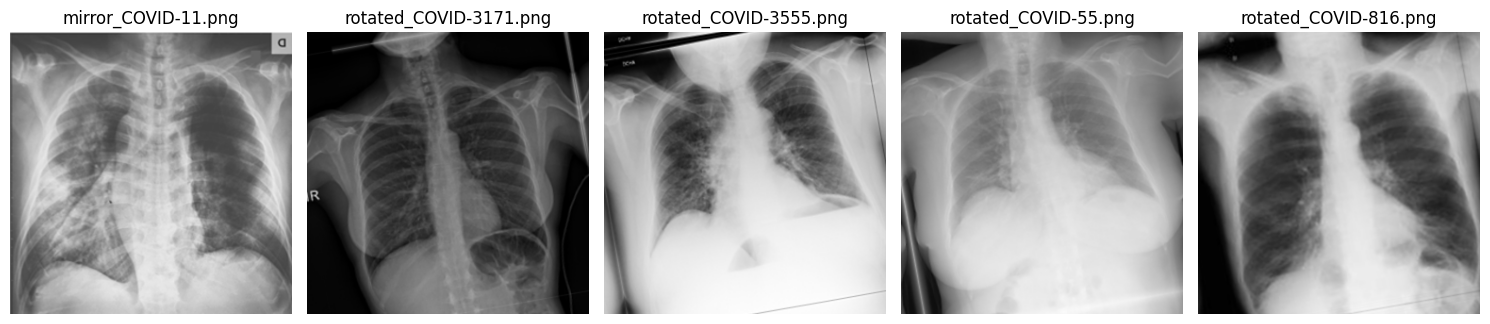

In [ ]:
sample_aug = data[data['Image'].str.contains('mirror|rotated|gamma_correct')].sample(5)

plt.figure(figsize=(15,5))
for i, row in enumerate(sample_aug.iterrows()):
    img = cv2.imread(row[1]['Image Path'])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(1,5,i+1)
    plt.imshow(img)
    plt.title(row[1]['Image'])
    plt.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
data['Class'].value_counts()

,count
Class,
covid,10848
normal,10192
lung opacity,6012
viral pneumonia,1345


In [ ]:
viral_data = data[data['Class'] == 'viral pneumonia']
augmented_data = []

viral_dir = viral
save_dir = "VIRAL_Augmented"
os.makedirs(save_dir, exist_ok=True)

for index, row in viral_data.iterrows():
    img_path = row['Image Path']

    img = cv2.imread(img_path)
    if img is None:
        continue

    flipped = cv2.flip(img, 1)

    new_name = f"mirror_{row['Image']}"

    new_path = os.path.join(save_dir, new_name)

    cv2.imwrite(new_path, flipped)

    augmented_data.append([new_name, new_path, "viral pneumonia", flipped.shape])

aug_df = pd.DataFrame(augmented_data, columns= data.columns)

viral_data = pd.concat([viral_data, aug_df], ignore_index=True)

for index, row in viral_data.iterrows():
    img_path = row['Image Path']

    img = cv2.imread(img_path)
    if img is None:
        continue

    h, w = img.shape[:2]
    center = (w // 2, h // 2)

    M = cv2.getRotationMatrix2D(center, 10, 1.0)
    rotated_pos = cv2.warpAffine(img, M, (w, h), borderMode=cv2.BORDER_REFLECT_101)

    M = cv2.getRotationMatrix2D(center, -10, 1.0)
    rotated_neg = cv2.warpAffine(img, M, (w, h), borderMode=cv2.BORDER_REFLECT_101)

    gamma = 0.7
    gamma_cor = np.array(255 * ((img / 255) ** (1/gamma)), dtype='uint8')

    new_name_pos = f"rotated_pos_{row['Image']}"
    new_name_neg = f"rotated_neg_{row['Image']}"
    new_name_cor = f"gamma_correct_{row['Image']}"

    new_path_pos = os.path.join(save_dir, new_name_pos)
    new_path_neg = os.path.join(save_dir, new_name_neg)
    new_path_cor = os.path.join(save_dir, new_name_cor)

    cv2.imwrite(new_path_pos, rotated_pos)
    cv2.imwrite(new_path_neg, rotated_neg)
    cv2.imwrite(new_path_cor, gamma_cor)

    augmented_data.append([new_name_pos, new_path_pos, "viral pneumonia", rotated_pos.shape])

    augmented_data.append([new_name_neg, new_path_neg, "viral pneumonia", rotated_neg.shape])

    augmented_data.append([new_name_cor, new_path_cor, "viral pneumonia", gamma_cor.shape])

aug_df = pd.DataFrame(augmented_data, columns= data.columns)

data = pd.concat([data, aug_df], ignore_index=True)

data.tail()


,Image,Image Path,Class,shape
37807,rotated_neg_mirror_Viral Pneumonia-347.png,VIRAL_Augmented/rotated_neg_mirror_Viral Pneum...,viral pneumonia,"(299, 299, 3)"
37808,gamma_correct_mirror_Viral Pneumonia-347.png,VIRAL_Augmented/gamma_correct_mirror_Viral Pne...,viral pneumonia,"(299, 299, 3)"
37809,rotated_pos_mirror_Viral Pneumonia-216.png,VIRAL_Augmented/rotated_pos_mirror_Viral Pneum...,viral pneumonia,"(299, 299, 3)"
37810,rotated_neg_mirror_Viral Pneumonia-216.png,VIRAL_Augmented/rotated_neg_mirror_Viral Pneum...,viral pneumonia,"(299, 299, 3)"
37811,gamma_correct_mirror_Viral Pneumonia-216.png,VIRAL_Augmented/gamma_correct_mirror_Viral Pne...,viral pneumonia,"(299, 299, 3)"


In [ ]:
data['Class'].value_counts()

,count
Class,
covid,10848
viral pneumonia,10760
normal,10192
lung opacity,6012


In [ ]:
lung_data = data[data['Class'] == 'lung opacity']
lung_data.reset_index(drop=True, inplace=True)
augmented_data = []

lung_dir = lung_opacity
save_dir = "LUNG_Augmented"
os.makedirs(save_dir, exist_ok=True)

for index, row in lung_data.iterrows():
    if index > 4000:
        break
    img_path = row['Image Path']

    img = cv2.imread(img_path)
    if img is None:
        continue

    flipped = cv2.flip(img, 1)

    new_name = f"mirror_{row['Image']}"
    new_path = os.path.join(save_dir, new_name)

    cv2.imwrite(new_path, flipped)

    augmented_data.append([new_name, new_path, "lung opacity", flipped.shape])


aug_df = pd.DataFrame(augmented_data, columns= data.columns)

data = pd.concat([data, aug_df], ignore_index=True)

data.tail()

,Image,Image Path,Class,shape
41808,mirror_Lung_Opacity-5072.png,LUNG_Augmented/mirror_Lung_Opacity-5072.png,lung opacity,"(299, 299, 3)"
41809,mirror_Lung_Opacity-2949.png,LUNG_Augmented/mirror_Lung_Opacity-2949.png,lung opacity,"(299, 299, 3)"
41810,mirror_Lung_Opacity-54.png,LUNG_Augmented/mirror_Lung_Opacity-54.png,lung opacity,"(299, 299, 3)"
41811,mirror_Lung_Opacity-2122.png,LUNG_Augmented/mirror_Lung_Opacity-2122.png,lung opacity,"(299, 299, 3)"
41812,mirror_Lung_Opacity-4744.png,LUNG_Augmented/mirror_Lung_Opacity-4744.png,lung opacity,"(299, 299, 3)"


In [ ]:
covid_df = data[data['Class'] == 'covid']
normal_df = data[data['Class'] == 'normal']
viral_df = data[data['Class'] == 'viral pneumonia']
lung_df = data[data['Class'] == 'lung opacity']

In [ ]:
n_covid = len(covid_df)
n_normal = len(normal_df)
n_viral = len(viral_df)
n_lung_opacity = len(lung_df)

n_images = [n_covid, n_normal, n_viral, n_lung_opacity]

fig = px.bar(
    x=list(imgs_dict.keys()),
    y=n_images,
    labels={'x': 'Class', 'y': 'N images'},
    title='Number of images per class'
)
fig.show()

In [ ]:
data['Class'].value_counts()

,count
Class,
covid,10848
viral pneumonia,10760
normal,10192
lung opacity,10013


In [ ]:
data['shape'].value_counts()

,count
shape,
"(299, 299, 3)",41813


In [ ]:
data['Path Exists'] = data['Image Path'].apply(lambda x: os.path.exists(x))
data['Path Exists'].value_counts()

,count
Path Exists,
True,41813


In [ ]:
train_df, temp_df = train_test_split(data, test_size= 0.3, stratify= data["Class"], random_state= 42)

val_df, test_df = train_test_split(temp_df, test_size= 0.5, stratify= temp_df["Class"], random_state= 42)

In [ ]:
train_df['Class'].value_counts()

,count
Class,
covid,7594
viral pneumonia,7532
normal,7134
lung opacity,7009


In [ ]:
def save_images(df, base_dir):
    for index, row in df.iterrows():
        class_dir = os.path.join(base_dir, row["Class"])
        os.makedirs(class_dir, exist_ok=True)

        src = row["Image Path"]
        dst = os.path.join(class_dir, row["Image"])

        shutil.copy(src, dst)

base_dir = "Dataset split"
os.makedirs(base_dir, exist_ok= True)

train = os.path.join(base_dir, "train")
val   = os.path.join(base_dir, "val")
test  = os.path.join(base_dir, "test")

os.makedirs(train, exist_ok= True)
os.makedirs(val,   exist_ok= True)
os.makedirs(test,  exist_ok= True)

save_images(train_df, train)
save_images(val_df, val)
save_images(test_df, test)

print("Train dir:", train)
print("Val dir:", val)
print("Test dir:", test)


Train dir: Dataset split/train
Val dir: Dataset split/val
Test dir: Dataset split/test


In [ ]:
os.listdir(train)

['viral pneumonia', 'covid', 'lung opacity', 'normal']

In [ ]:
def count_images(base_dir):
    count = 0
    for file in os.listdir(base_dir):
        count += len(os.listdir(os.path.join(base_dir, file)))
    return count

print(count_images(train))
print(count_images(test))
print(count_images(val))

38710
11653
11632


# Training

In [ ]:
IMG_SIZE = 299
input_shape = (IMG_SIZE, IMG_SIZE, 3)
num_classes = 4

base_model = tf.keras.applications.InceptionV3(input_shape=input_shape, include_top=False, weights='imagenet')

base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
predictions = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 299, 299,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_94 (Conv2D)  │ (None, 149, 149,  │        864 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 149, 149,  │         96 │ conv2d_94[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_94       │ (None, 149, 149,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_95 (Conv2D)  │ (None, 147, 147,  │      9,216 │ activation_94[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 147, 147,  │         96 │ conv2d_95[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_95       │ (None, 147, 147,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_96 (Conv2D)  │ (None, 147, 147,  │     18,432 │ activation_95[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 147, 147,  │        192 │ conv2d_96[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_96       │ (None, 147, 147,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 73, 73,    │          0 │ activation_96[0]… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_97 (Conv2D)  │ (None, 73, 73,    │      5,120 │ max_pooling2d_4[… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 73, 73,    │        240 │ conv2d_97[0][0]   │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_97       │ (None, 73, 73,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_98 (Conv2D)  │ (None, 71, 71,    │    138,240 │ activation_97[0]… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 71, 71,    │        576 │ conv2d_98[0][0]   │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_98       │ (None, 71, 71,    │          0 │ batch_normalizat

 Total params: 21,810,980 (83.20 MB)

 Trainable params: 8,196 (32.02 KB)

 Non-trainable params: 21,802,784 (83.17 MB)

# ImageDataGenerator

In [ ]:
data_gen = ImageDataGenerator(rescale=1./255)

train_gen_data = data_gen.flow_from_directory(
    train,
    target_size=(299, 299),
    batch_size=32,
    shuffle=True,
    class_mode='categorical'
)

val_gen_data = data_gen.flow_from_directory(
    val,
    target_size=(299, 299),
    batch_size=32,
    shuffle=False,
    class_mode='categorical'
)

test_gen_data = data_gen.flow_from_directory(
    test,
    target_size=(299, 299),
    batch_size=32,
    shuffle=False,
    class_mode='categorical'
)


Found 38710 images belonging to 4 classes.
Found 11632 images belonging to 4 classes.
Found 11653 images belonging to 4 classes.


In [ ]:
#Unfreeze top layers of InceptionV3
base_model.trainable = True

#Freeze the first 200 layers
for layer in base_model.layers[:200]:
    layer.trainable = False

#Recompile with a lower learning rate
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
#Retrain with early stopping

fine_tune_history = model.fit(
    train_gen_data,
    validation_data=val_gen_data,
    epochs=10,
    callbacks=[
        EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2),
        tf.keras.callbacks.ModelCheckpoint('fine_tuned_model.keras', save_best_only=True)
    ]
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning:

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.



Epoch 1/10
1210/1210 ━━━━━━━━━━━━━━━━━━━━ 382s 288ms/step - accuracy: 0.7564 - loss: 0.6110 - val_accuracy: 0.9540 - val_loss: 0.1366 - learning_rate: 1.0000e-05
Epoch 2/10
1210/1210 ━━━━━━━━━━━━━━━━━━━━ 313s 259ms/step - accuracy: 0.9469 - loss: 0.1555 - val_accuracy: 0.9785 - val_loss: 0.0679 - learning_rate: 1.0000e-05
Epoch 3/10
1210/1210 ━━━━━━━━━━━━━━━━━━━━ 310s 256ms/step - accuracy: 0.9737 - loss: 0.0785 - val_accuracy: 0.9875 - val_loss: 0.0425 - learning_rate: 1.0000e-05
Epoch 4/10
1210/1210 ━━━━━━━━━━━━━━━━━━━━ 314s 259ms/step - accuracy: 0.9878 - loss: 0.0407 - val_accuracy: 0.9909 - val_loss: 0.0299 - learning_rate: 1.0000e-05
Epoch 5/10
1210/1210 ━━━━━━━━━━━━━━━━━━━━ 309s 255ms/step - accuracy: 0.9954 - loss: 0.0194 - val_accuracy: 0.9922 - val_loss: 0.0291 - learning_rate: 1.0000e-05
Epoch 6/10
1210/1210 ━━━━━━━━━━━━━━━━━━━━ 313s 259ms/step - accuracy: 0.9963 - loss: 0.0130 - val_accuracy: 0.9927 - val_loss: 0.0296 - learning_rate: 1.0000e-05
Epoch 7/10
1210/1210 ━━━━━━━

# Evaluation

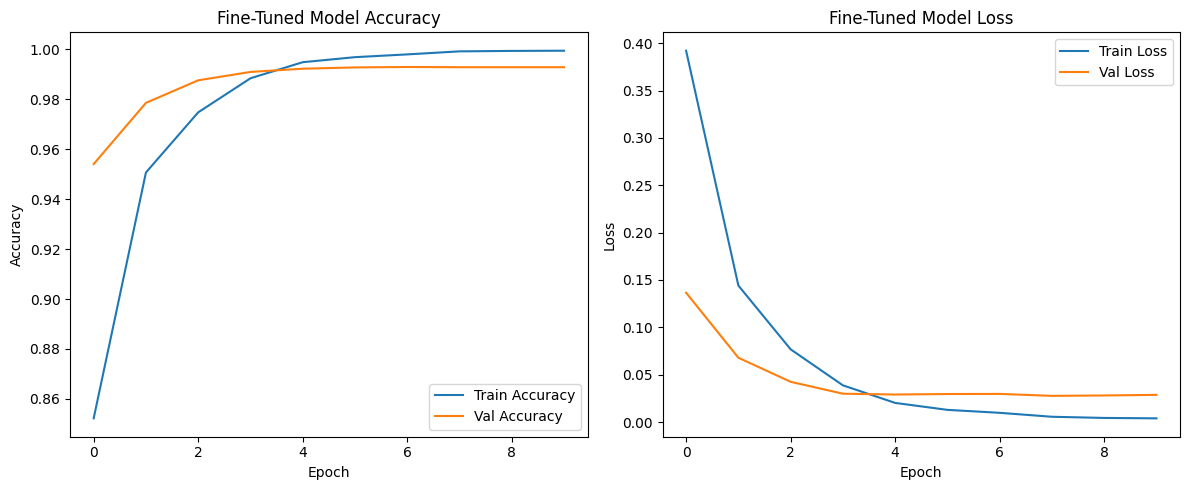

In [ ]:
# Plot fine-tuning accuracy and loss
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(fine_tune_history.history['accuracy'], label='Train Accuracy')
plt.plot(fine_tune_history.history['val_accuracy'], label='Val Accuracy')
plt.title('Fine-Tuned Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(fine_tune_history.history['loss'], label='Train Loss')
plt.plot(fine_tune_history.history['val_loss'], label='Val Loss')
plt.title('Fine-Tuned Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
# Evaluate model performance on test data
test_loss, test_accuracy = model.evaluate(test_gen_data)
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")

365/365 ━━━━━━━━━━━━━━━━━━━━ 82s 224ms/step - accuracy: 0.9938 - loss: 0.0243
Test Accuracy: 0.9929
Test Loss: 0.0251


1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step


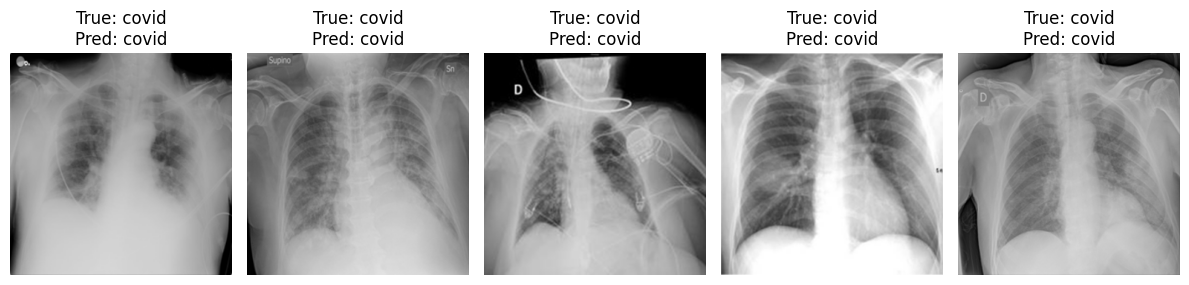

In [ ]:
# Get class labels
class_names = list(test_gen_data.class_indices.keys())

# Get a batch of test images
images, labels = next(test_gen_data)

# Predict
predictions = model.predict(images)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(labels, axis=1)

# Plot first 5 predictions
plt.figure(figsize=(12, 6))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(images[i])
    plt.title(f"True: {class_names[true_classes[i]]}\nPred: {class_names[predicted_classes[i]]}")
    plt.axis('off')
plt.tight_layout()
plt.show()

365/365 ━━━━━━━━━━━━━━━━━━━━ 82s 204ms/step


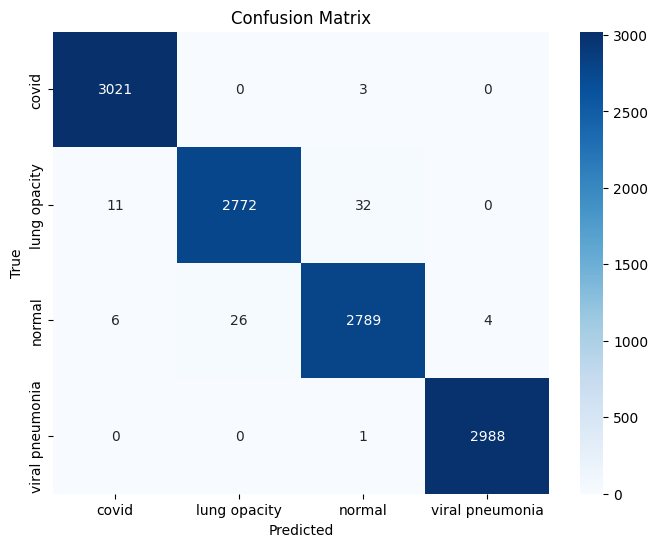

Classification Report:
                  precision    recall  f1-score   support

          covid       0.99      1.00      1.00      3024
   lung opacity       0.99      0.98      0.99      2815
         normal       0.99      0.99      0.99      2825
viral pneumonia       1.00      1.00      1.00      2989

       accuracy                           0.99     11653
      macro avg       0.99      0.99      0.99     11653
   weighted avg       0.99      0.99      0.99     11653



In [ ]:
# Get class labels
class_names = list(test_gen_data.class_indices.keys())

# Predict on the entire test dataset
predictions = model.predict(test_gen_data)
predicted_classes = np.argmax(predictions, axis=1)

# Get true labels for the entire test dataset
true_classes = test_gen_data.classes

cm = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

print("Classification Report:\n", classification_report(true_classes, predicted_classes, target_names=class_names))

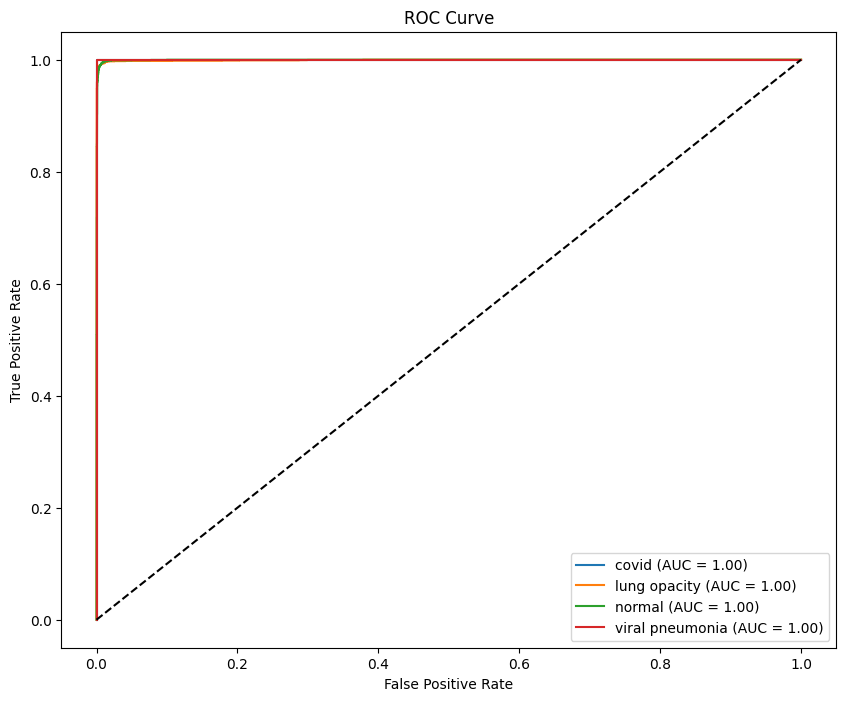

In [ ]:
y_true_bin = label_binarize(true_classes, classes=[0,1,2,3])
y_pred_bin = predictions

plt.figure(figsize=(10,8))
for i in range(len(class_names)):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_pred_bin[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{class_names[i]} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


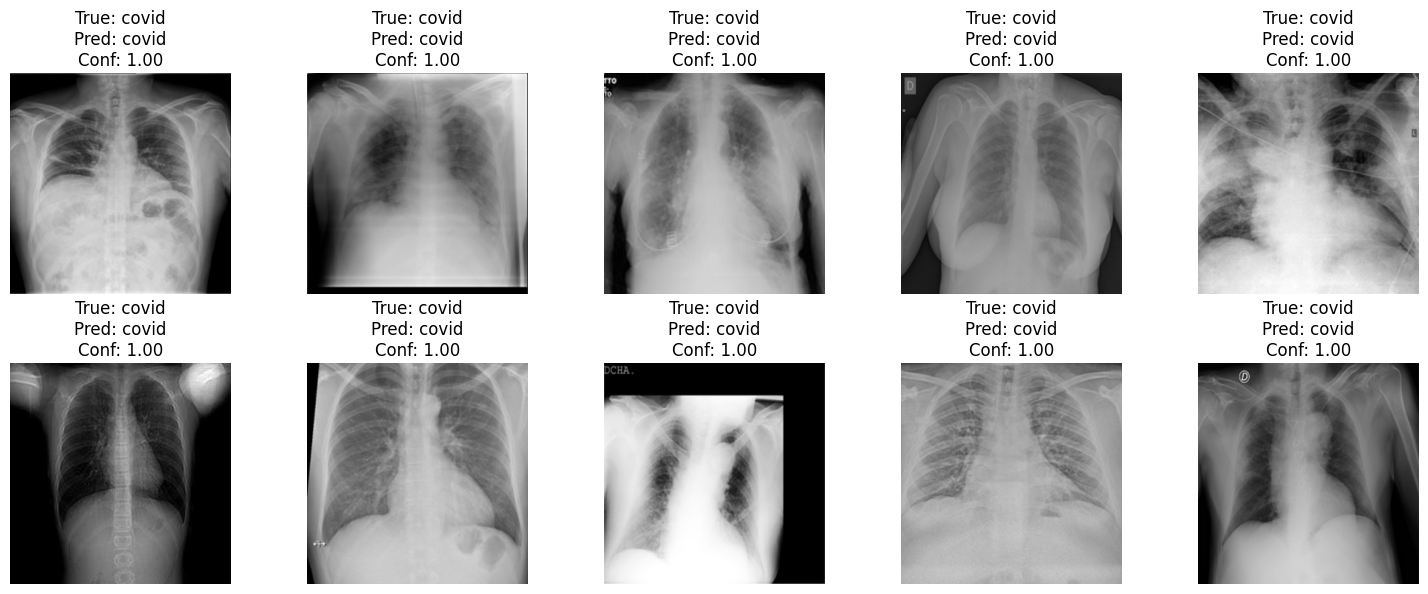

In [ ]:
images, labels = next(test_gen_data)
predictions = model.predict(images)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(labels, axis=1)
plt.figure(figsize=(15, 6))
for i in range(10):  # Show 10 images
    plt.subplot(2, 5, i + 1)
    plt.imshow(images[i])
    true_label = class_names[true_classes[i]]
    pred_label = class_names[predicted_classes[i]]
    confidence = np.max(predictions[i])
    plt.title(f"True: {true_label}\nPred: {pred_label}\nConf: {confidence:.2f}")
    plt.axis('off')
plt.tight_layout()
plt.show()


In [ ]:
misclassified = np.where(predicted_classes != true_classes)[0]
plt.figure(figsize=(15, 6))
for i, idx in enumerate(misclassified[:10]):
    plt.subplot(2, 5, i + 1)
    plt.imshow(images[idx])
    true_label = class_names[true_classes[idx]]
    pred_label = class_names[predicted_classes[idx]]
    confidence = np.max(predictions[idx])
    plt.title(f"True: {true_label}\nPred: {pred_label}\nConf: {confidence:.2f}")
    plt.axis('off')
plt.tight_layout()
plt.show()


<Figure size 1500x600 with 0 Axes>